In [19]:
%matplotlib inline

In [20]:
%run notebook_setup.py

In [13]:
import pandas as pd
import numpy as np

In [16]:
data = pd.read_csv("../data/sector1_2_2_medians.csv")

In [18]:
time = np.array(data["start_time"])

In [17]:
flux = np.array(data["median_flux"])

In [22]:
inds = np.argsort(time)
time = time[inds]
flux = flux[inds]

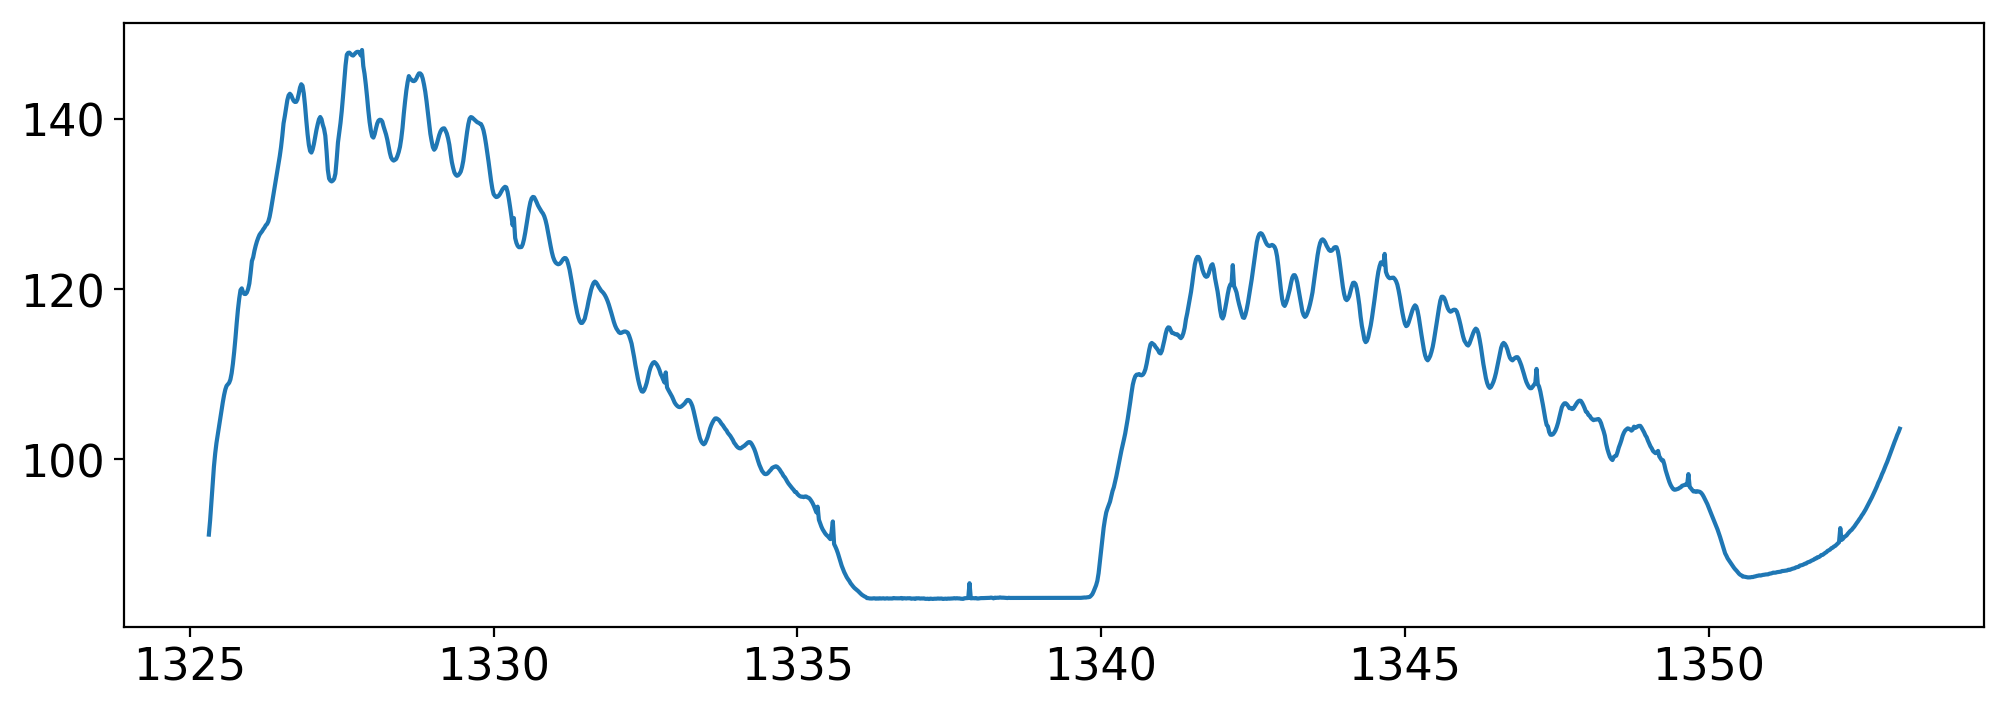

In [24]:
plt.plot(time, flux);

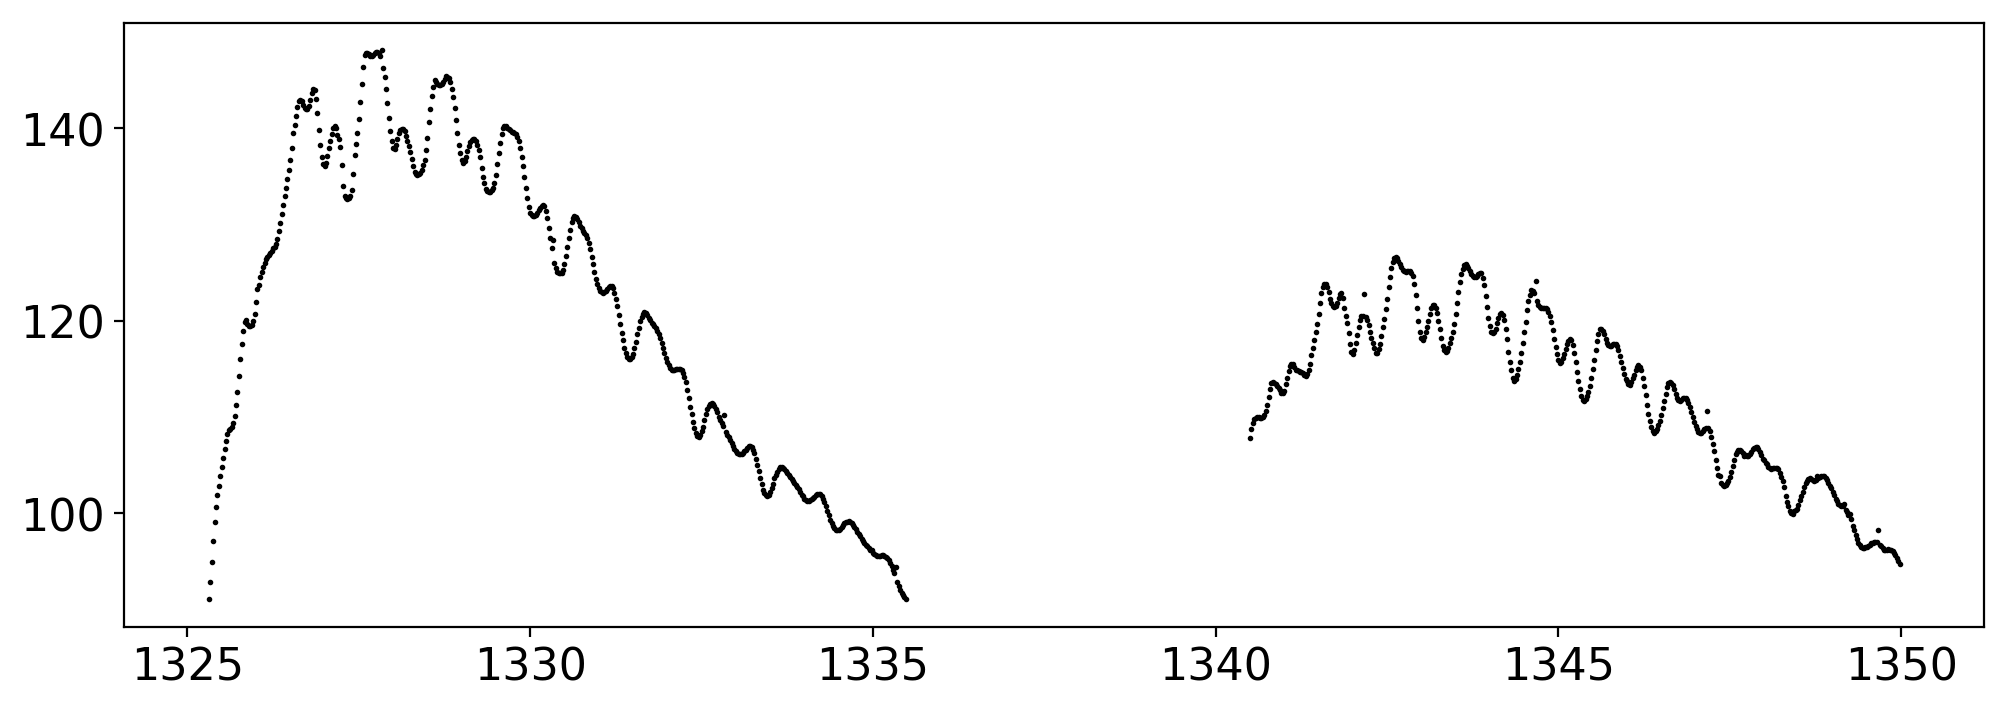

In [173]:
no_earth = np.where(((time > 1335.5) & (time < 1340.5)) |
                    ((time > 1350))
                   )[0]

time = np.delete(time, no_earth)
flux = np.delete(flux, no_earth)
plt.plot(time, flux, 'k.', ms=2);

In [250]:
import celerite
from celerite import terms

In [251]:
kernel = (terms.SHOTerm(-5.1764392316836405, 1.6107542577563405, 2.655821848765415) + terms.SHOTerm(-5.7045029853481175, 3.2344017903155295, 1.8378770664093453) + terms.JitterTerm(-3.17071374788726) + terms.Matern32Term(-0.7774349567978974, -0.7022573115788371, eps=0.01))

In [252]:
gp = celerite.GP(kernel, mean=np.mean(flux))
gp.compute(time, 1e-5)

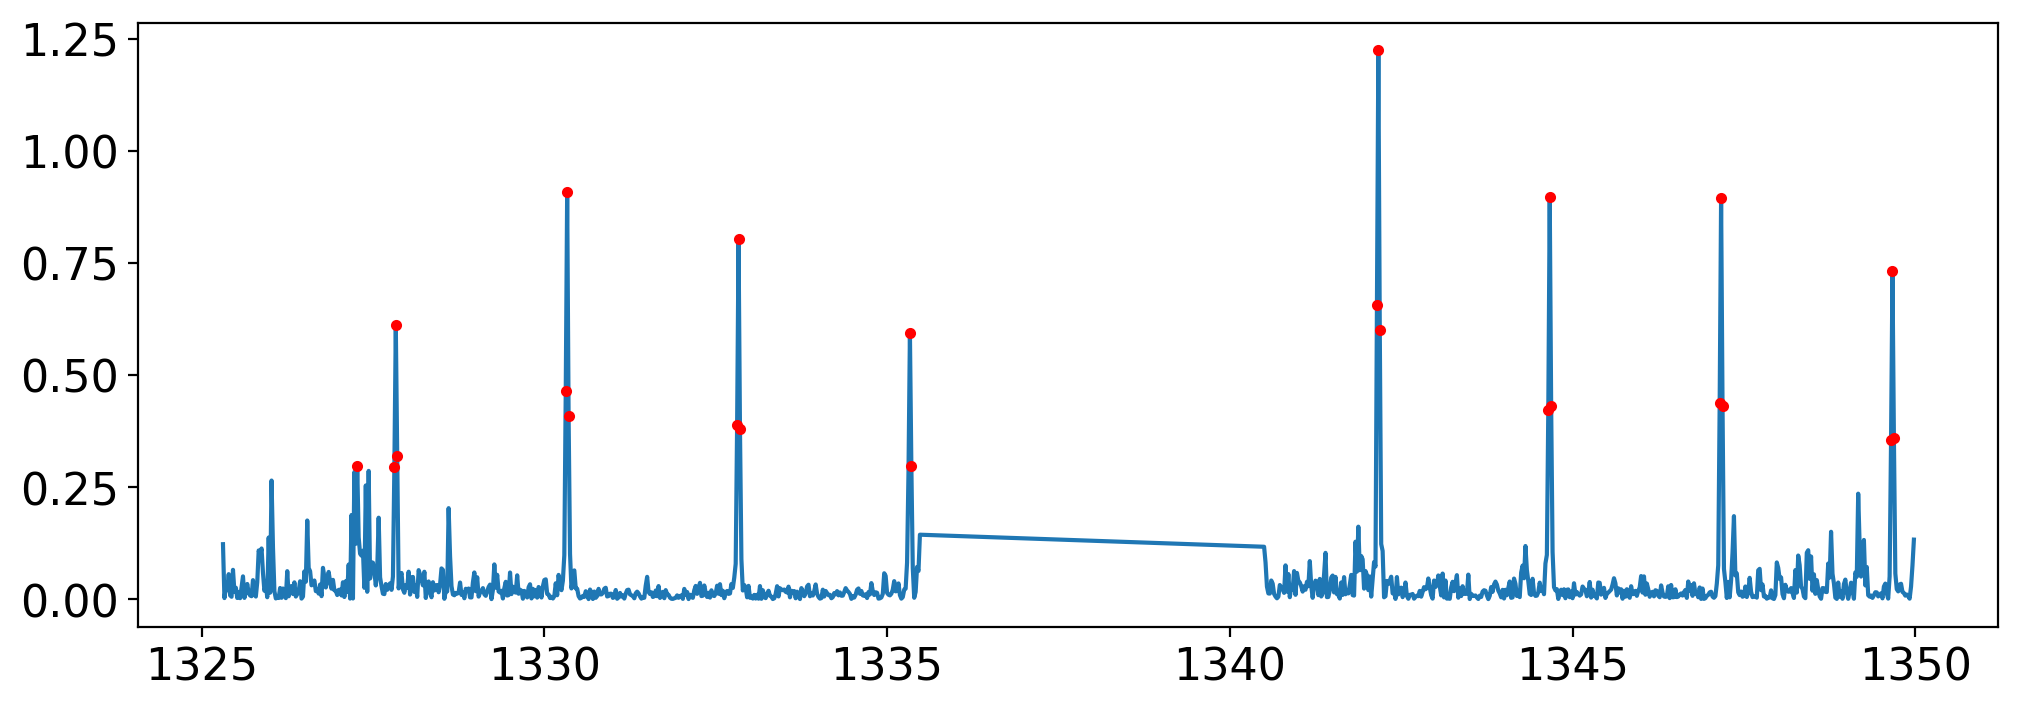

In [276]:
pred_mean = gp.predict(flux, time, return_var=False)[0]
resid = np.abs(flux - pred_mean)
cut = 3 * np.std(resid)
plt.plot(time, resid)
bad = np.where(resid > cut)
plt.plot(time[bad], resid[bad], 'r.')

time = np.delete(time, bad)
flux = np.delete(flux, bad)

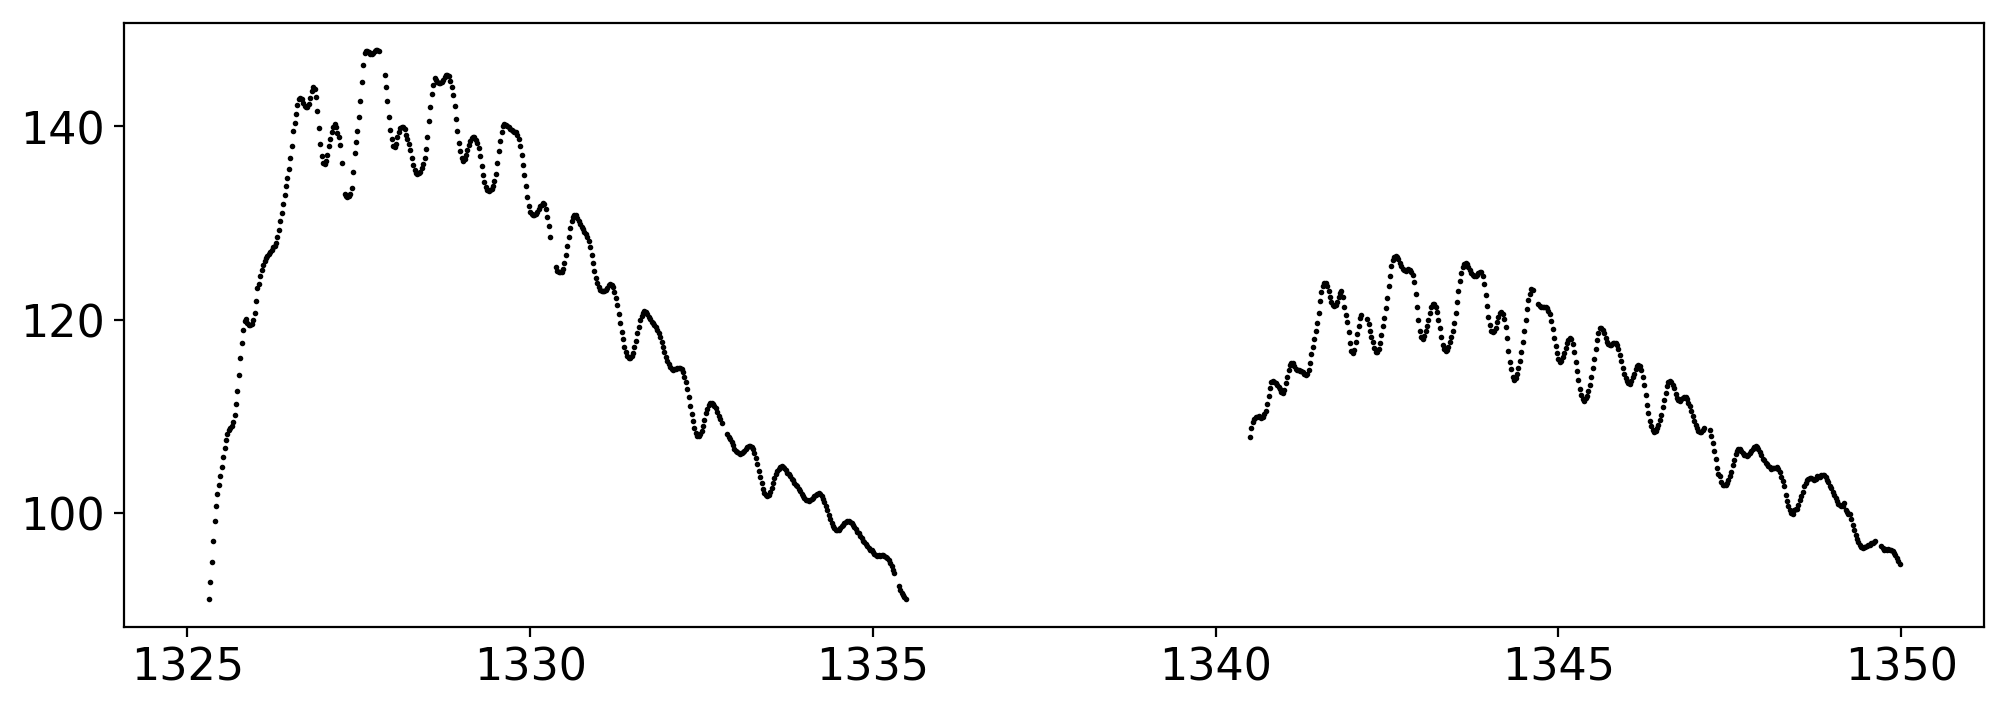

In [277]:
plt.plot(time, flux, 'k.', ms=2);

In [278]:
housekeeping1 = pd.read_csv("../data/emi_S1_O9_d-54.dat", sep="\s+", header=1)
housekeeping1.columns

Index(['#SCTime', 'Date', 'Time', 'D(days)', 'C1-E', 'C2-E', 'C3-E', 'C4-E',
       'C1-M', 'C2-M', 'C3-M', 'C4-M', 'EDist', 'Mdist', 'FIN', 'TJD'],
      dtype='object')

In [279]:
housekeeping2 = pd.read_csv("../data/emangles_S1_O9_d-54.dat", sep="\s+", header=0)
housekeeping2.columns

Index(['#SCTime', 'Date', 'Time', 'D(days)', 'E:alt', 'E:az', 'E:dist',
       'M:alt', 'M:az', 'M:dist', 'FIN', 'TJD'],
      dtype='object')

In [280]:
EDist = np.array(housekeeping1["EDist"])
EDist /= np.max(EDist)
MDist = np.array(housekeeping1["Mdist"])
MDist /= np.max(MDist)

A = np.hstack((
    np.ones_like(time).reshape(-1, 1),
    np.interp(time, np.array(housekeeping1["TJD"]), np.cos(np.pi / 180 * np.array(housekeeping1["C2-E"]))).reshape(-1, 1),
    np.interp(time, np.array(housekeeping1["TJD"]), np.sin(np.pi / 180 * np.array(housekeeping1["C2-E"]))).reshape(-1, 1),
    np.interp(time, np.array(housekeeping1["TJD"]), np.cos(np.pi / 180 * np.array(housekeeping1["C2-M"]))).reshape(-1, 1),
    np.interp(time, np.array(housekeeping1["TJD"]), np.sin(np.pi / 180 * np.array(housekeeping1["C2-M"]))).reshape(-1, 1),
    np.interp(time, np.array(housekeeping1["TJD"]), EDist).reshape(-1, 1),
    np.interp(time, np.array(housekeeping1["TJD"]), MDist).reshape(-1, 1),
    np.interp(time, np.array(housekeeping2["TJD"]), np.cos(np.pi / 180 * np.array(housekeeping2["E:az"]))).reshape(-1, 1),
    np.interp(time, np.array(housekeeping2["TJD"]), np.sin(np.pi / 180 * np.array(housekeeping2["E:az"]))).reshape(-1, 1),
    np.interp(time, np.array(housekeeping2["TJD"]), np.cos(np.pi / 180 * np.array(housekeeping2["M:az"]))).reshape(-1, 1),
    np.interp(time, np.array(housekeeping2["TJD"]), np.sin(np.pi / 180 * np.array(housekeeping2["M:az"]))).reshape(-1, 1),
    np.interp(time, np.array(housekeeping2["TJD"]), np.cos(np.pi / 180 * np.array(housekeeping2["E:alt"]))).reshape(-1, 1),
    np.interp(time, np.array(housekeeping2["TJD"]), np.sin(np.pi / 180 * np.array(housekeeping2["E:alt"]))).reshape(-1, 1),
    np.interp(time, np.array(housekeeping2["TJD"]), np.cos(np.pi / 180 * np.array(housekeeping2["M:alt"]))).reshape(-1, 1),
    np.interp(time, np.array(housekeeping2["TJD"]), np.sin(np.pi / 180 * np.array(housekeeping2["M:alt"]))).reshape(-1, 1)
))

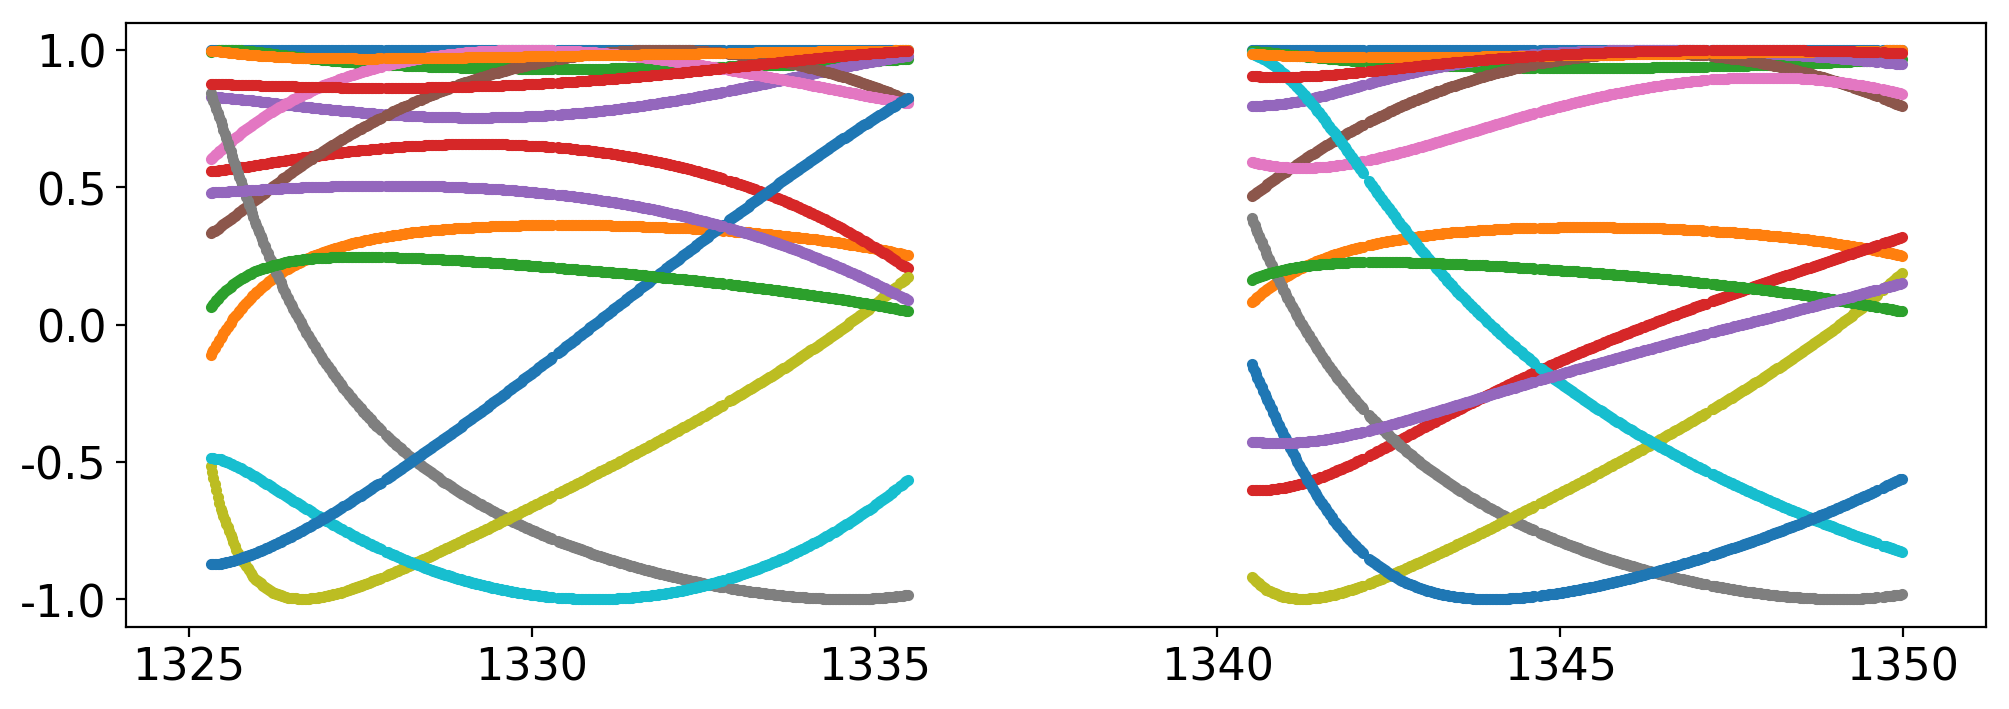

In [281]:
plt.plot(time, A, '.');

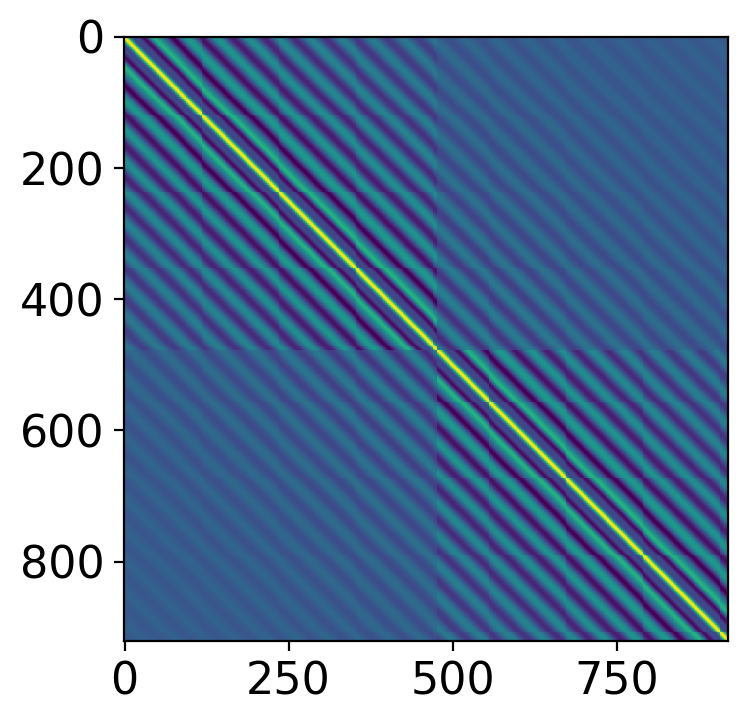

In [284]:
gp.compute(time, 1e-5)
Sigma = gp.get_matrix()
plt.imshow(Sigma);

In [285]:
LInv = np.eye(A.shape[1])
W = np.dot(A.T, np.linalg.solve(Sigma, A)) + LInv
what = np.linalg.solve(W, np.dot(A.T, np.linalg.solve(Sigma, flux)))

In [286]:
what

array([ 17.16394243,  10.25563993,  16.25560054,   6.92671963,
         6.10723415,   7.89750927,  16.45568151,  -6.59003175,
       -38.85738948,   0.94977078,  -2.43262806,  15.5054085 ,
         9.05389846,  10.82726015,   8.29160496])

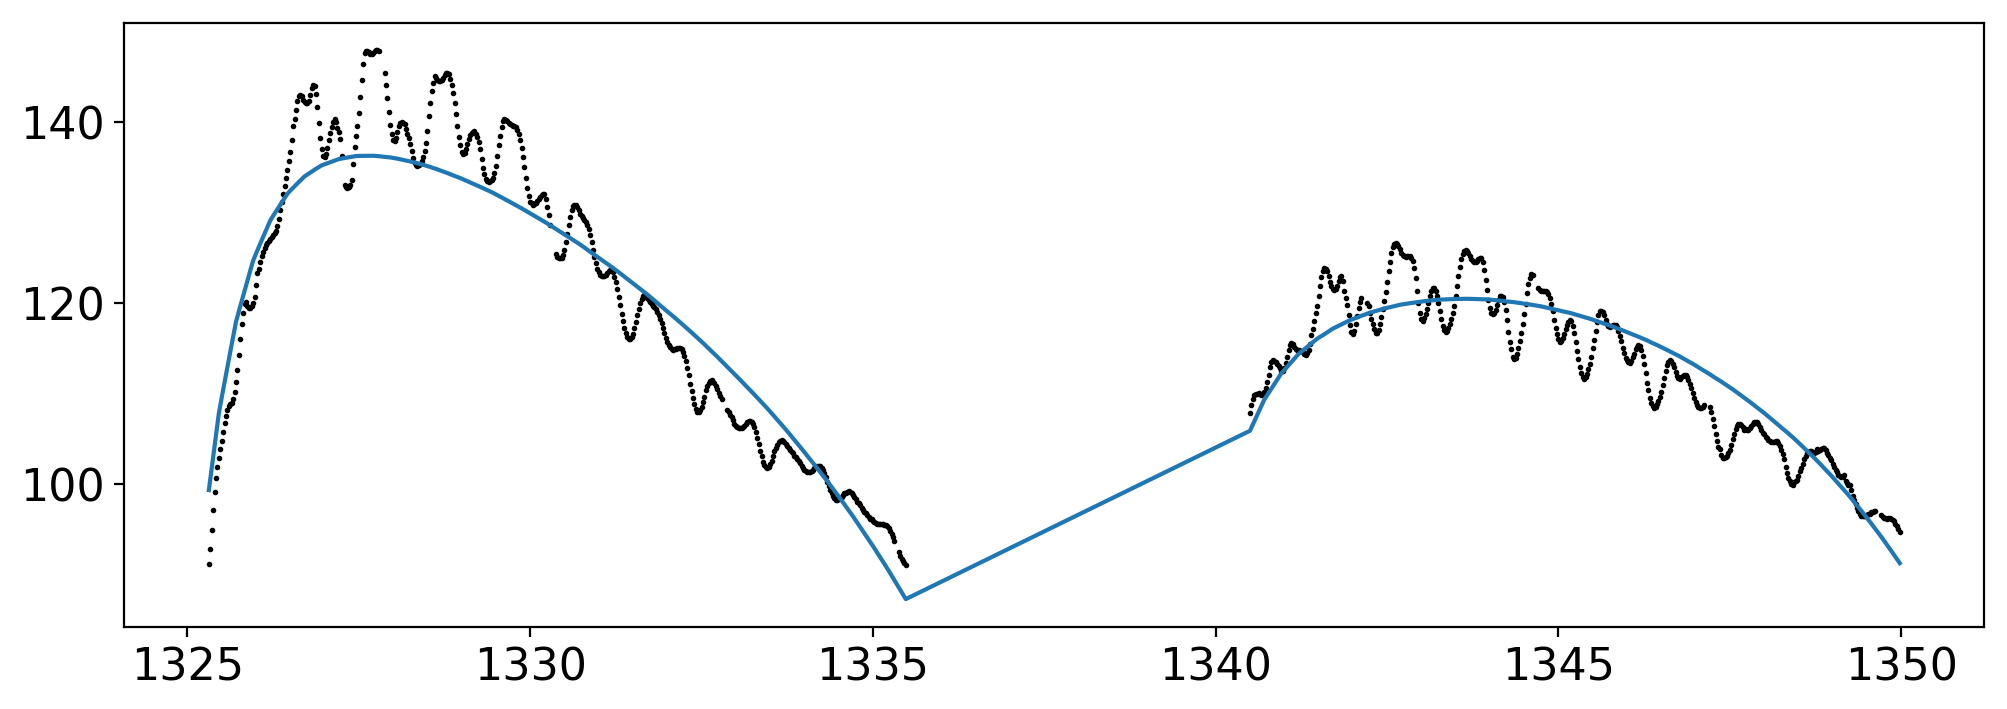

In [287]:
plt.plot(time, flux, 'k.', ms=2)
plt.plot(time, np.dot(A, what))

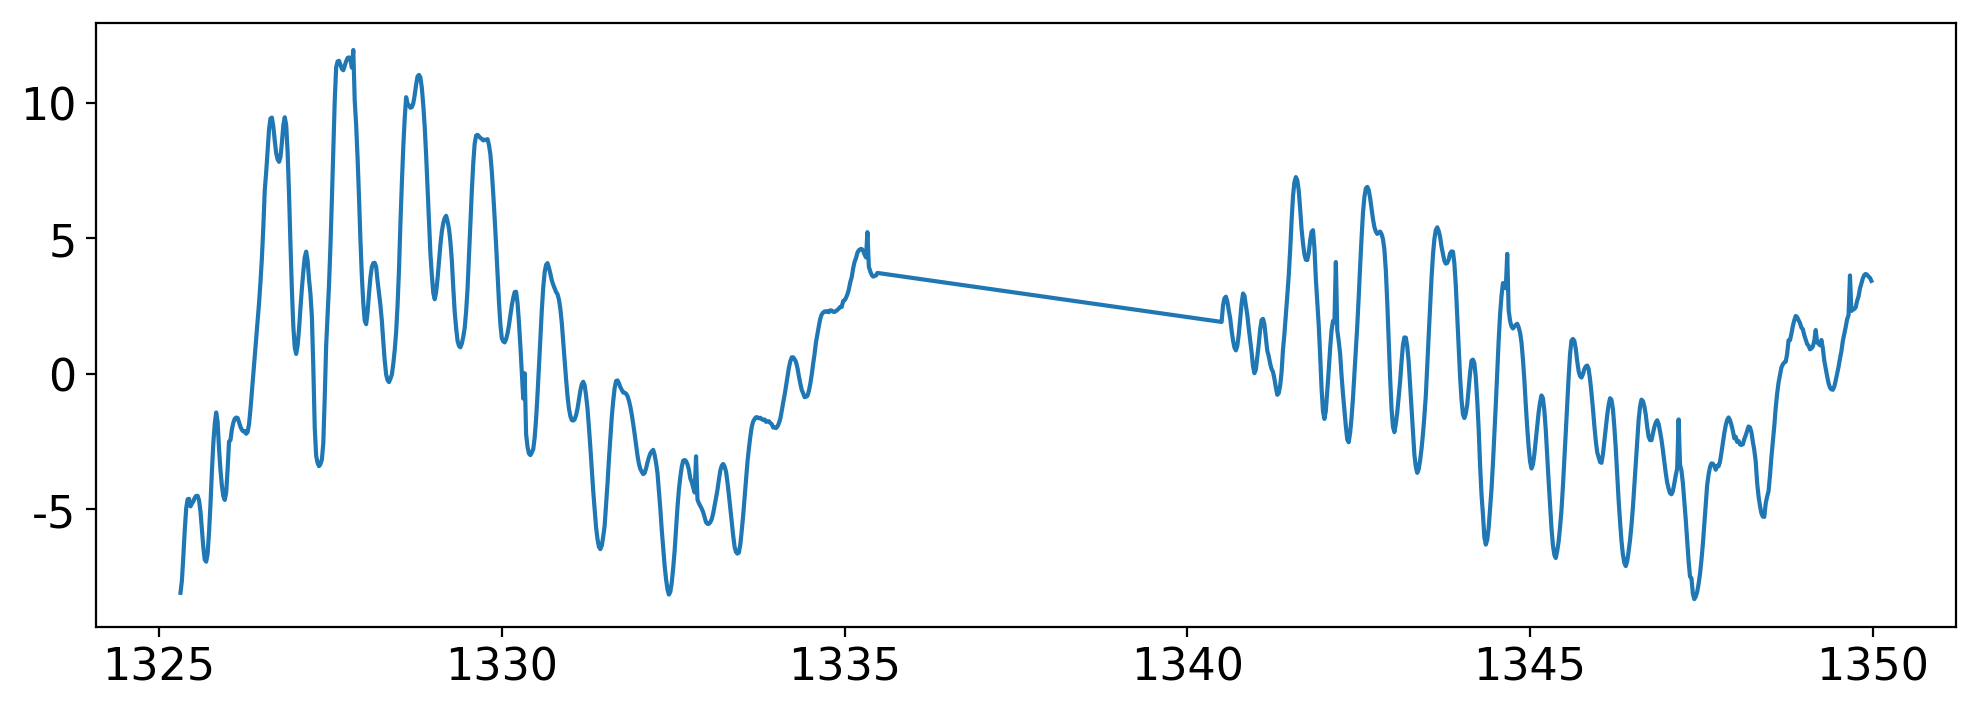

In [264]:
plt.plot(time, flux - np.dot(A, what));

In [288]:
A2 = np.hstack((
                    A,
                    A[:, 5].reshape(-1, 1) ** 2,
                    A[:, 6].reshape(-1, 1) ** 2,
                    A[:, 5].reshape(-1, 1) ** 3,
                    A[:, 6].reshape(-1, 1) ** 3,
                    A[:, 5].reshape(-1, 1) ** 4,
                    A[:, 6].reshape(-1, 1) ** 4,
                    A[:, 5].reshape(-1, 1) ** 5,
                    A[:, 6].reshape(-1, 1) ** 5,
                    A[:, 5].reshape(-1, 1) ** 6,
                    A[:, 6].reshape(-1, 1) ** 6
               ))

In [289]:
LInv = np.eye(A2.shape[1])
W = np.dot(A2.T, np.linalg.solve(Sigma, A2)) + LInv
what2 = np.linalg.solve(W, np.dot(A2.T, np.linalg.solve(Sigma, flux)))

In [290]:
what2

array([ 15.09660784,   8.78124955,  13.86731759,   3.17284133,
         9.2787075 ,  11.61916874,  10.68810612,  -3.86871505,
       -35.65407882,   1.26072427,  -2.69137992,  13.76747666,
         8.11885191,  10.95602409,   4.26391633,   6.20457796,
         7.59006688,   1.23860038,   5.45744406,  -2.73202719,
         4.04411374,  -5.74767261,   3.16901166,  -7.9922841 ,
         2.69593677])

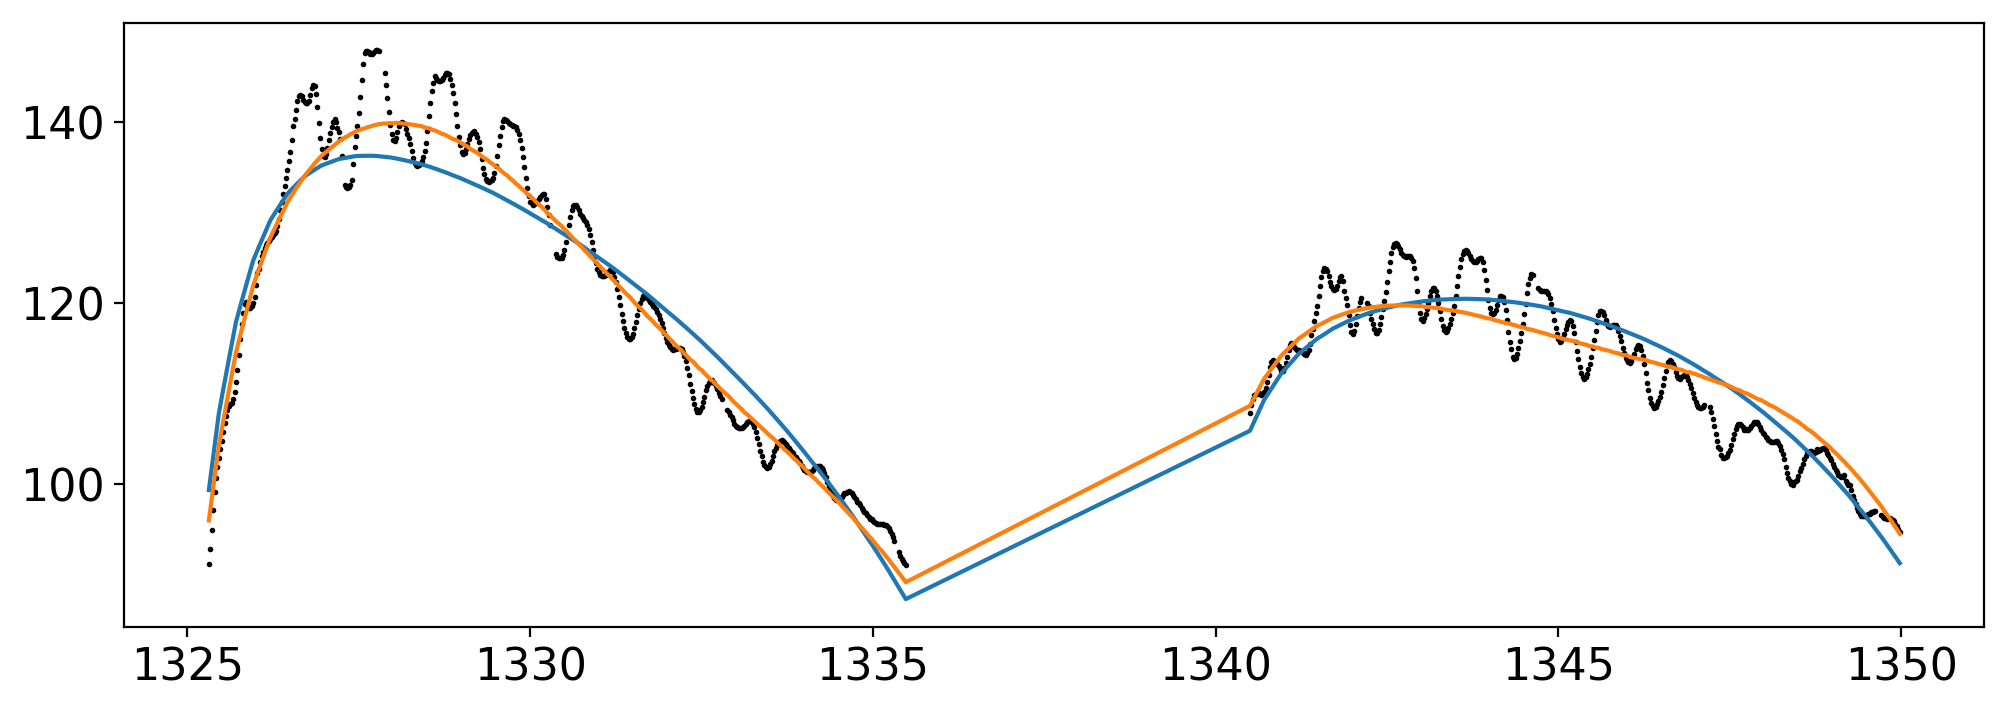

In [291]:
plt.plot(time, flux, 'k.', ms=2)
plt.plot(time, np.dot(A, what))
plt.plot(time, np.dot(A2, what2))

In [585]:
plt.plot(time, flux - np.dot(A2, what2))

TypeError: unsupported operand type(s) for -: 'function' and 'float'

In [546]:
import starry_beta as starry
import warnings
warnings.simplefilter("ignore")

In [294]:
map = starry.Map(20)
map.load_image("earth")

In [552]:
def is_visible(x, y, phase):
    if (x ** 2 + y ** 2) > 1:
        return False
    elif (phase < 0):
        b = 2 * phase / np.pi + 1
        yterm = np.abs(np.sqrt(1 - (x / b) ** 2))
        if (phase > -np.pi / 2) and ((x < 0) or ((x > 0) and (np.abs(y) < yterm))):
            return True
        elif (x < 0) and not (np.abs(y) < yterm):
            return True
        else:
            return False
    else:
        b = 2 * phase / np.pi - 1
        yterm = np.abs(np.sqrt(1 - (x / b) ** 2))
        if (phase > np.pi / 2) and (x > 0) and not (np.abs(y) < yterm):
            return True
        elif (phase >= 0) and (phase <= np.pi / 2) and ((x > 0) or (np.abs(y) < yterm)):
                return True
        else:
            return False

In [553]:
def image(map, theta, phase, res=100):
    x, y = np.meshgrid(np.linspace(-1, 1, res), np.linspace(-1, 1, res))
    image = np.zeros((res, res)) * np.nan
    for i, x in enumerate(np.linspace(-1, 1, res)):
        for j, y in enumerate(np.linspace(-1, 1, res)):
            if is_visible(x, y, phase):
                image[j, i] = map(theta=theta, x=x, y=y)
    return image

In [556]:
def flux(map, theta=0, phase=0, res=100):
    x, y = np.meshgrid(np.linspace(-1, 1, res), np.linspace(-1, 1, res))
    flux = 0
    for x in np.linspace(-1, 1, res):
        for y in np.linspace(-1, 1, res):
            if is_visible(x, y, phase):
                flux += map(theta=theta, x=x, y=y)
    return flux / ((res / 2.) ** 2)

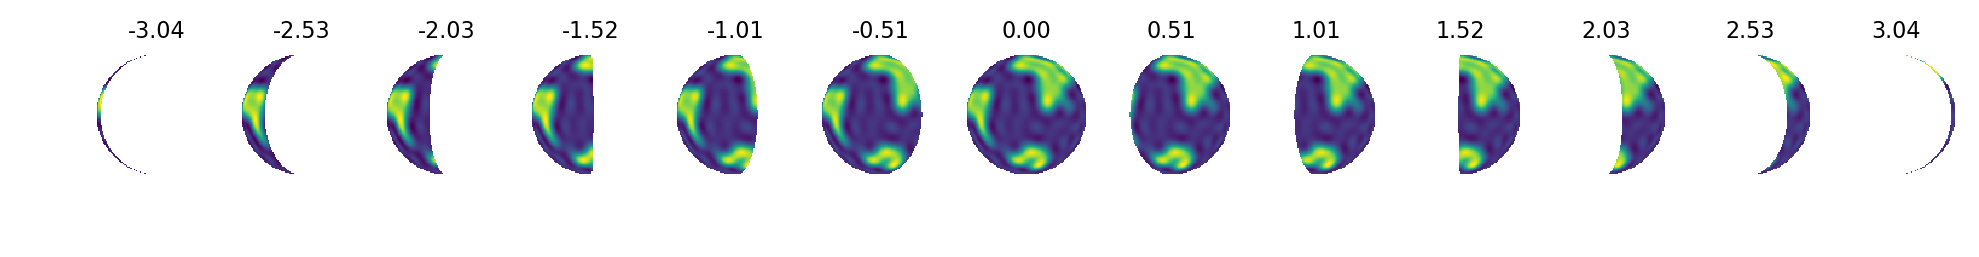

In [583]:
map = starry.Map(20)
map.load_image("earth")
map.axis = [1, 0, 0]
map.rotate(-40)
map.axis = [0, np.cos(40 * np.pi / 180), -np.sin(40 * np.pi / 180)]
fig, ax = plt.subplots(1, 13)
for i, phase in enumerate(np.linspace(-np.pi + 0.1, np.pi - 0.1, 13)):
    ax[i].imshow(image(map, 0, phase), origin="lower")
    ax[i].set_title("%.2f" % phase, fontsize=8)
    ax[i].axis('off')

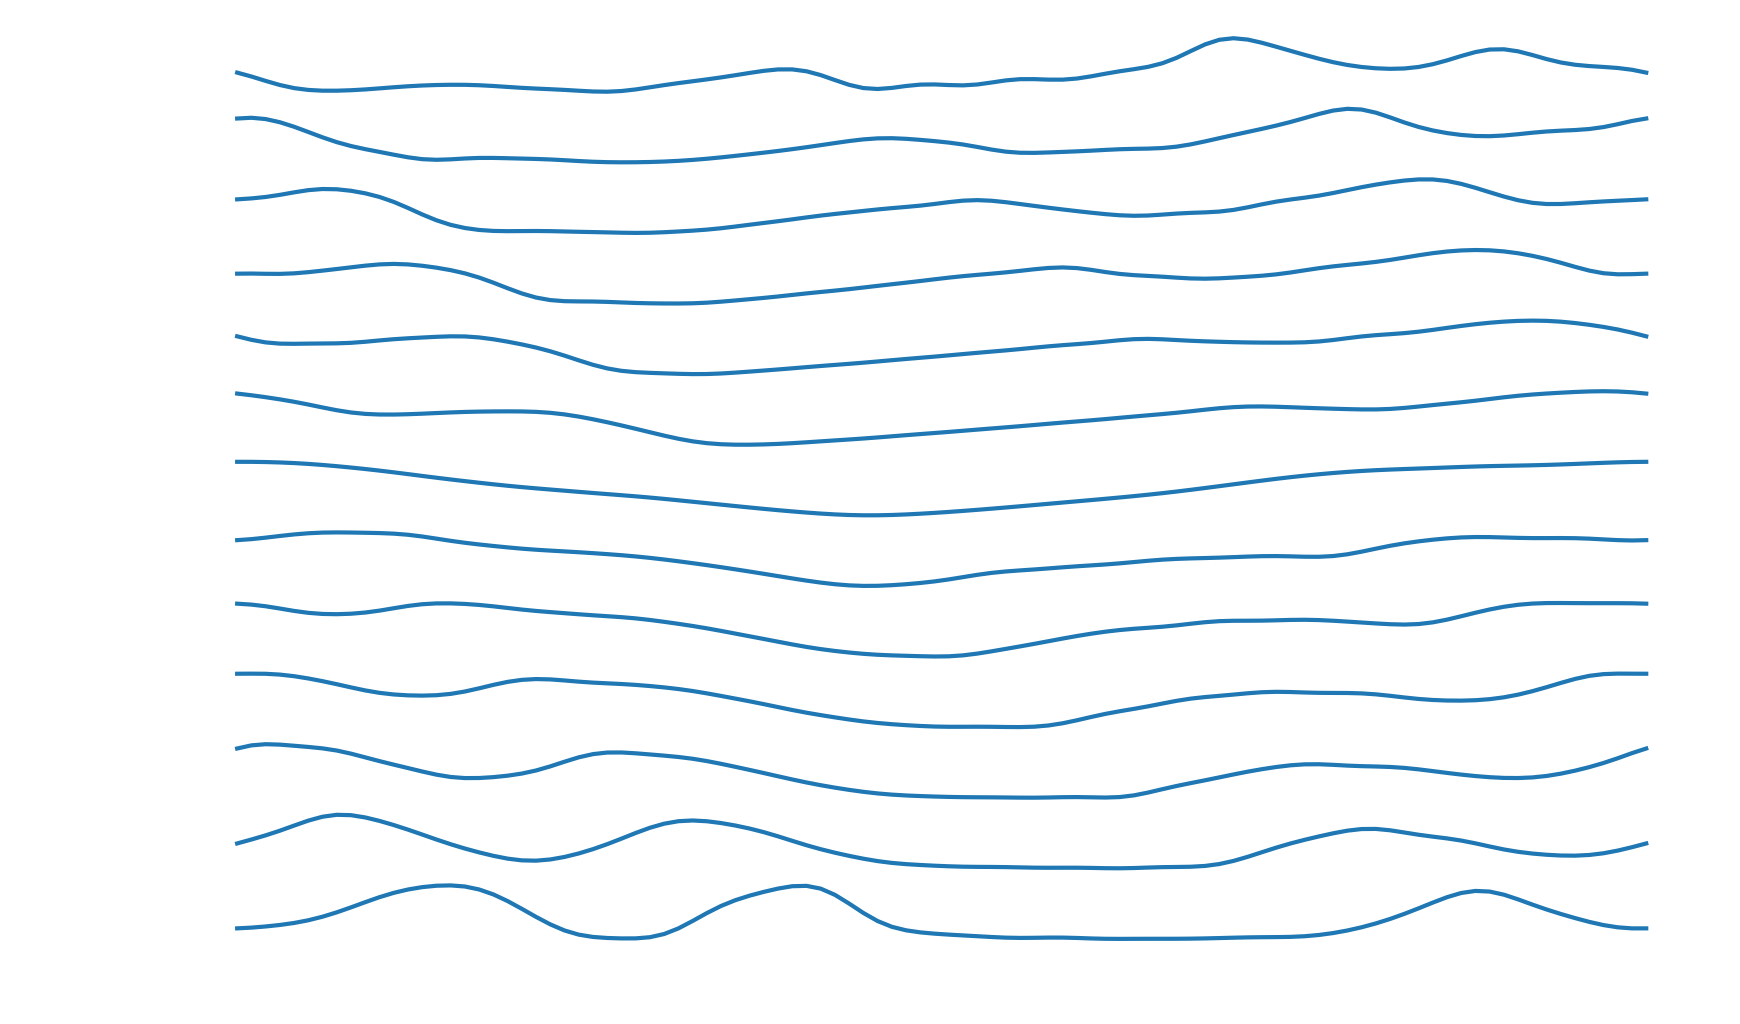

In [584]:
theta = np.linspace(0, 360, 100)
fig, ax = plt.subplots(13, figsize=(10, 6))
for i, phase in enumerate(np.linspace(-np.pi + 0.1, np.pi - 0.1, 13)):
    ax[i].plot(theta, flux(map, theta, phase))
    ax[i].axis('off')

In [592]:
theta = np.linspace(0, 14 * 360, 300)
phase = np.linspace(-np.pi + 0.1, np.pi - 0.1, 300)
phasecurve = [flux(map, theta[i], phase[i]) for i in range(300)]

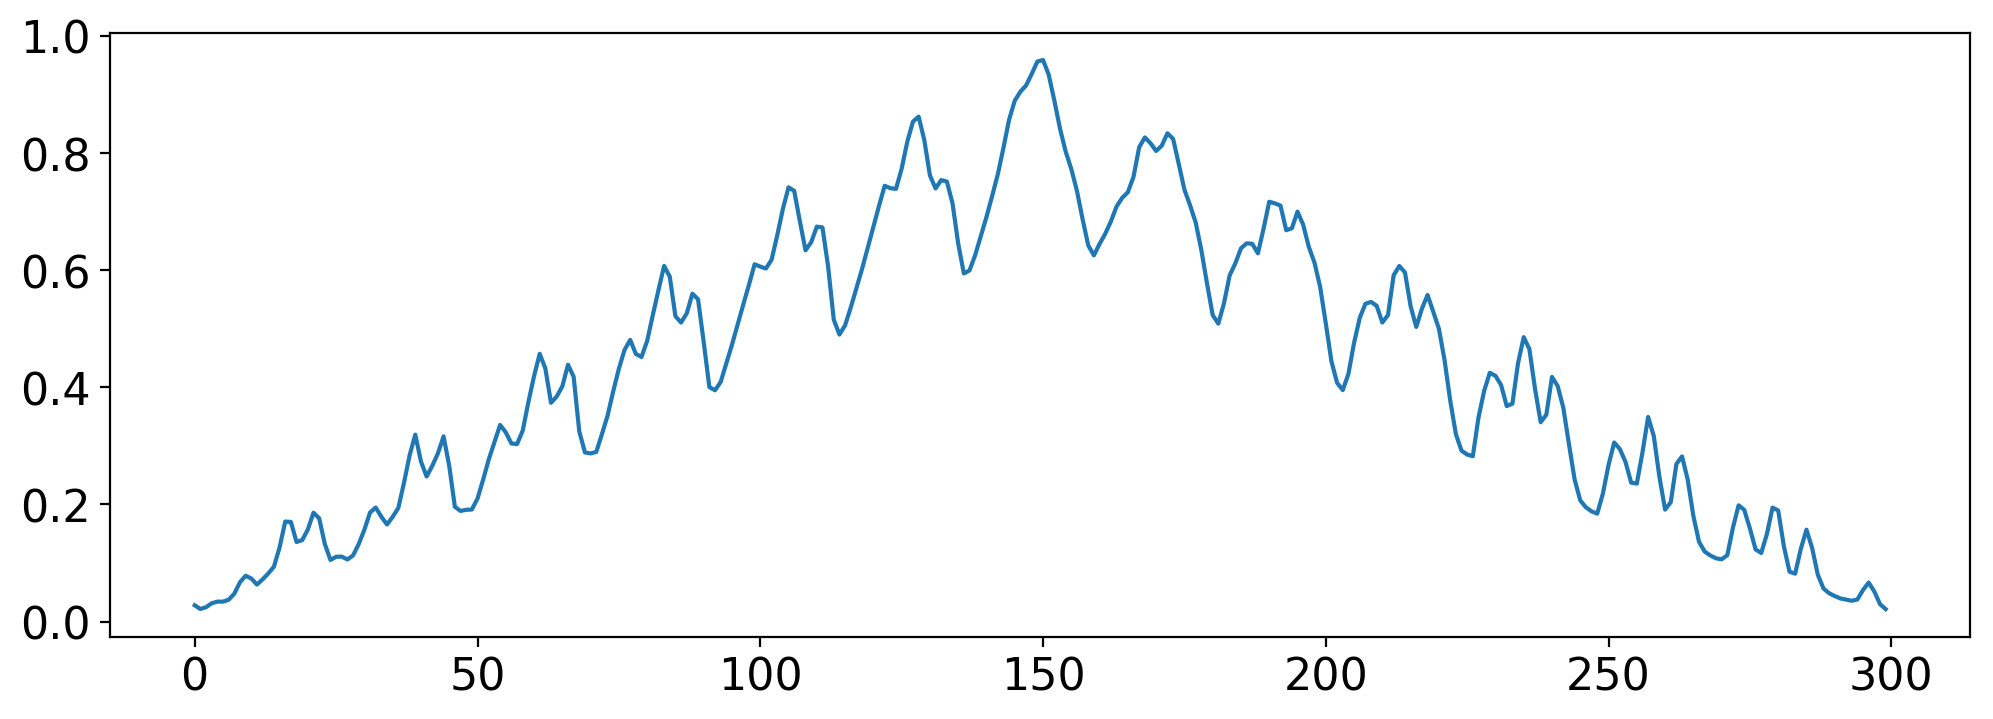

In [593]:
plt.plot(phasecurve)